# Impact of Bias-Variance tradeoff on model performance for medical image analysis
---
Brain tumor are abnormal masses of cells in the brain that can be either cancerous (malignant) or noncancerous (benign). Given the confined space within the skull, any such growth can lead to severe complications, including increased intracranial pressure, brain damage, and potentially life-threatening conditions. Early detection and accurate classification of brain tumor are therefore essential for effective treatment and improved patient outcomes. This study investigates the bias-variance tradeoff in classifying brain tumor using MRI images categorized into four types: glioma, meningioma, no Tumor, and pituitary Tumor. To understand the implications of model complexity on prediction accuracy, we initially train three models with varying levels of complexity: a simple dense model (characterized by high bias and low variance), a shallow CNN (providing an intermediate complexity), and a deep CNN based on ResNet50 (low bias but high variance). After analysing training and validation performance across these models, we use a balanced intermediate model to minimize both bias (underfitting) and variance (overfitting), achieving high accuracy while maintaining generalizability. This exploration of the bias-variance tradeoff in medical image analysis provides valuable insights into the risks of overfitting and underfitting, guiding the development of optimal models for accurate, reliable medical diagnostics. Such approaches hold promise for enhancing healthcare outcomes by supporting precise and consistent brain Tumor classification.

In [ ]:
!pip install tensorflow

In [3]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 1.1 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/11.0 MB 1.1 MB/s eta 0:00:10
   --- ------------------------------------ 1.0/11.0 MB 1.0 MB/s eta 0:00:10
   --- ------------------------------------ 1.0/11.0 MB 1.0 MB/s eta 0:00:10
   ---- ----------------------------------- 1.3/11.0 MB 882.6 kB/s eta 0:00:11
   ---- ----------------------------------- 1.3/11.0 MB 882.6 kB/s eta 0:00:11
   ----- ---------------------------------- 1.6/11.0 MB 830.6 kB/s eta 0:00:12
   ----- ---------------------------------- 1.6/11.0 MB 830.6 kB/s eta 0:00:12
   ------ --------------------------------- 1.8/11.0 MB 780.2 kB/s eta 0:00:12
   ------

In [7]:
!pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [84]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50

In [29]:
import kagglehub

DATA_PATH = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", DATA_PATH)

TRAINING_PATH = os.path.join(DATA_PATH, 'Training')
TESTING_PATH = os.path.join(DATA_PATH, 'Testing')

CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']


Path to dataset files: C:\Users\Arjun Arora\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


In [30]:
def display_sample_images(data_path, categories):
    plt.figure(figsize=(10, 10))
    for i, category in enumerate(categories):
        image_folder = os.path.join(data_path, category)
        image_file = os.listdir(image_folder)[0]
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 2, i + 1)
        plt.imshow(image)
        plt.title(category)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

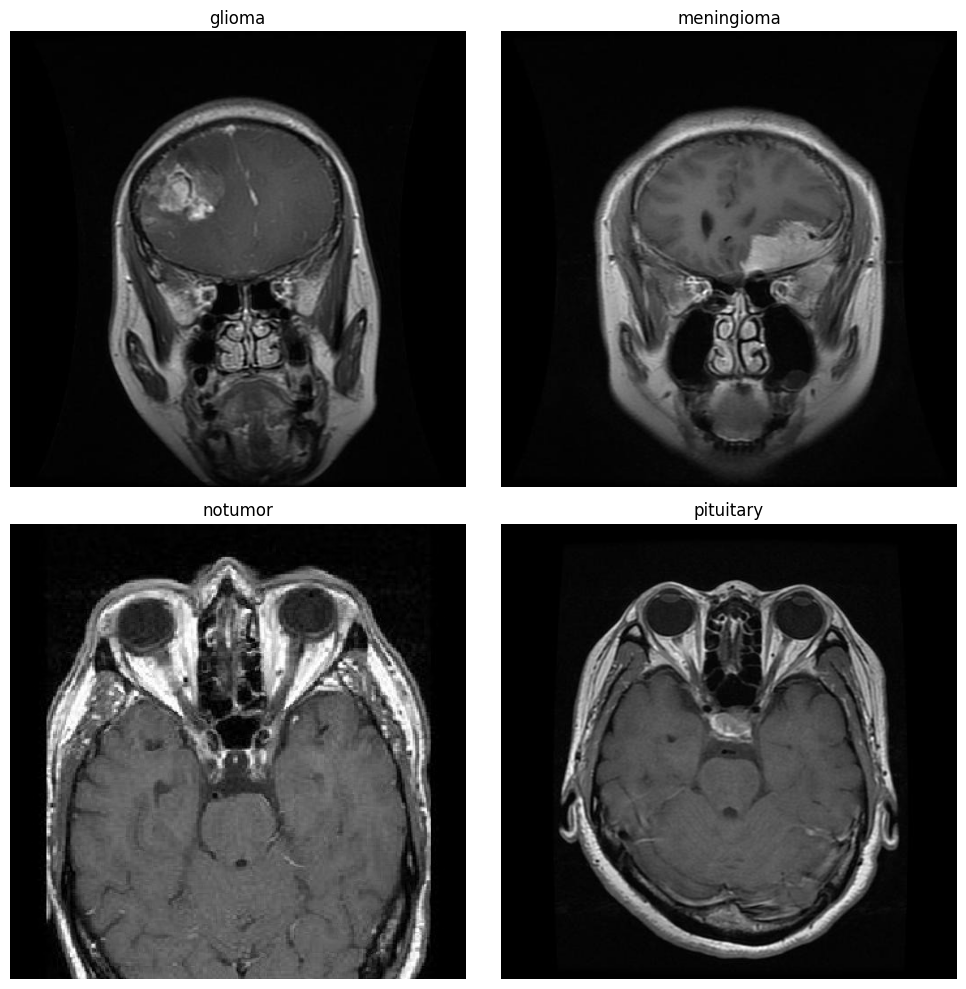

In [31]:
display_sample_images(TRAINING_PATH, CATEGORIES)

In [32]:
IMAGE_SIZE = (224, 224)

def load_images_and_labels(data_path, categories, image_size):
    images = []
    labels = []

    for label, category in enumerate(categories):
        folder_path = os.path.join(data_path, category)
        if not os.path.exists(folder_path):
            print(f"Directory not found: {folder_path}")
            continue

        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(label)

    return np.array(images), np.array(labels)


In [33]:
X_train, y_train = load_images_and_labels(TRAINING_PATH, CATEGORIES, IMAGE_SIZE)
X_train = X_train / 255.0
y_train = to_categorical(y_train, num_classes=len(CATEGORIES))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_test, y_test = load_images_and_labels(TESTING_PATH, CATEGORIES, IMAGE_SIZE)
X_test = X_test / 255.0
y_test = to_categorical(y_test, num_classes=len(CATEGORIES))

In [34]:
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 4569
Validation set size: 1143
Test set size: 1311


In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Simple model with a single dense layer



In [36]:
simple_model = Sequential([
    Flatten(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    Dense(128, activation='relu'),
    Dense(len(CATEGORIES), activation='softmax')
])

simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │      19,267,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,268,228 (73.50 MB)

 Trainable params: 19,268,228 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

# Shallow CNN model

In [37]:
shallow_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(CATEGORIES), activation='softmax')
])
shallow_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

shallow_cnn.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
deep_cnn = Sequential([
    ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(len(CATEGORIES), activation='softmax')
])

deep_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

deep_cnn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [39]:
# Training simple model
history_simple = simple_model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 360ms/step - accuracy: 0.2930 - loss: 11.2117 - val_accuracy: 0.3053 - val_loss: 3.1487
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 348ms/step - accuracy: 0.3227 - loss: 3.7828 - val_accuracy: 0.3482 - val_loss: 2.2326
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 347ms/step - accuracy: 0.3416 - loss: 2.6239 - val_accuracy: 0.3088 - val_loss: 1.8983
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - accuracy: 0.3421 - loss: 2.0342 - val_accuracy: 0.3657 - val_loss: 1.3777
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 343ms/step - accuracy: 0.3301 - loss: 1.3418 - val_accuracy: 0.2843 - val_loss: 1.3045
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 347ms/step - accuracy: 0.3028 - loss: 1.3200 - val_accuracy: 0.3998 - val_loss: 1.3159
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 342ms/step - accuracy: 0.3333 - loss: 1.3025 - val_accuracy: 0.3753 - val_loss: 1.2987
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 341ms/step - accuracy: 0.3812 - loss: 

In [40]:
# Training shallow CNN
history_shallow = shallow_cnn.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 663ms/step - accuracy: 0.3380 - loss: 2.1138 - val_accuracy: 0.5774 - val_loss: 0.9184
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - accuracy: 0.6030 - loss: 0.9329 - val_accuracy: 0.6492 - val_loss: 0.8124
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 656ms/step - accuracy: 0.6656 - loss: 0.8065 - val_accuracy: 0.7340 - val_loss: 0.6742
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 669ms/step - accuracy: 0.6882 - loss: 0.7593 - val_accuracy: 0.7192 - val_loss: 0.6738
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 653ms/step - accuracy: 0.7218 - loss: 0.6918 - val_accuracy: 0.7279 - val_loss: 0.6717
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 652ms/step - accuracy: 0.7101 - loss: 0.7276 - val_accuracy: 0.7034 - val_loss: 0.7484
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 658ms/step - accuracy: 0.7364 - loss: 0.6512 - val_accuracy: 0.7647 - val_loss: 0.6190
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 649ms/step - accuracy: 0.7406 - loss: 0

In [65]:
# Training deep CNN (ResNet50)
history_deep = deep_cnn.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 862s 6s/step - accuracy: 0.9520 - loss: 0.1411 - val_accuracy: 0.6019 - val_loss: 1.2637
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 821s 6s/step - accuracy: 0.9567 - loss: 0.1184 - val_accuracy: 0.7743 - val_loss: 0.6544
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 879s 6s/step - accuracy: 0.9638 - loss: 0.1089 - val_accuracy: 0.8600 - val_loss: 0.5221
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 838s 6s/step - accuracy: 0.9595 - loss: 0.1167 - val_accuracy: 0.2738 - val_loss: 3.9519
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 847s 6s/step - accuracy: 0.9604 - loss: 0.1123 - val_accuracy: 0.8661 - val_loss: 0.5193
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 859s 6s/step - accuracy: 0.9609 - loss: 0.1123 - val_accuracy: 0.9221 - val_loss: 0.2474
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 895s 6s/step - accuracy: 0.9649 - loss: 0.1010 - val_accuracy: 0.2966 - val_loss: 5.4007
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 893s 6s/step - accuracy: 0.9630 - loss: 0.1144 - val_accu

In [66]:
# Evaluate simple model
test_loss_simple, test_acc_simple = simple_model.evaluate(X_test, y_test)
print(f"Simple Model Test Accuracy: {test_acc_simple}")

# Evaluate shallow CNN
test_loss_shallow, test_acc_shallow = shallow_cnn.evaluate(X_test, y_test)
print(f"Shallow CNN Test Accuracy: {test_acc_shallow}")

# Evaluate deep CNN (ResNet50)
test_loss_deep, test_acc_deep = deep_cnn.evaluate(X_test, y_test)
print(f"Deep CNN (ResNet50) Test Accuracy: {test_acc_deep}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5552 - loss: 1.1757
Simple Model Test Accuracy: 0.5369946360588074
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.7060 - loss: 0.7353
Shallow CNN Test Accuracy: 0.7780320644378662
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9418 - loss: 0.2009
Deep CNN (ResNet50) Test Accuracy: 0.8802440762519836


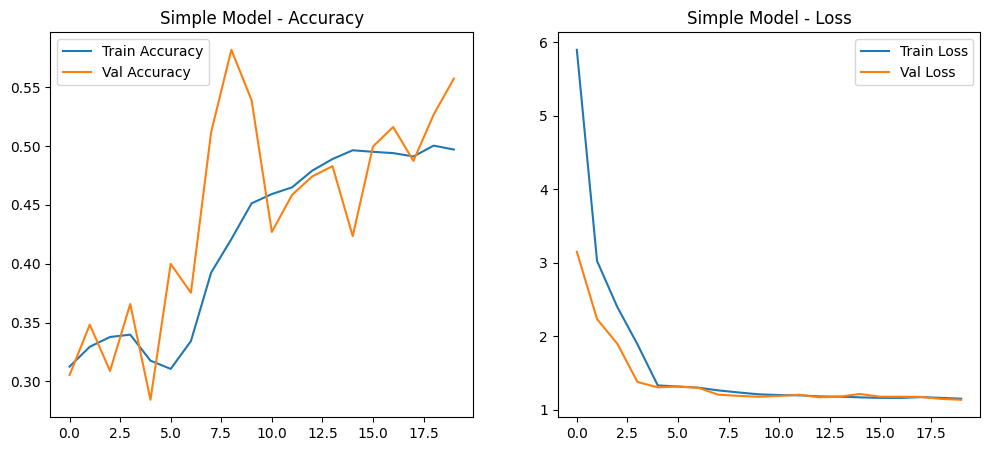

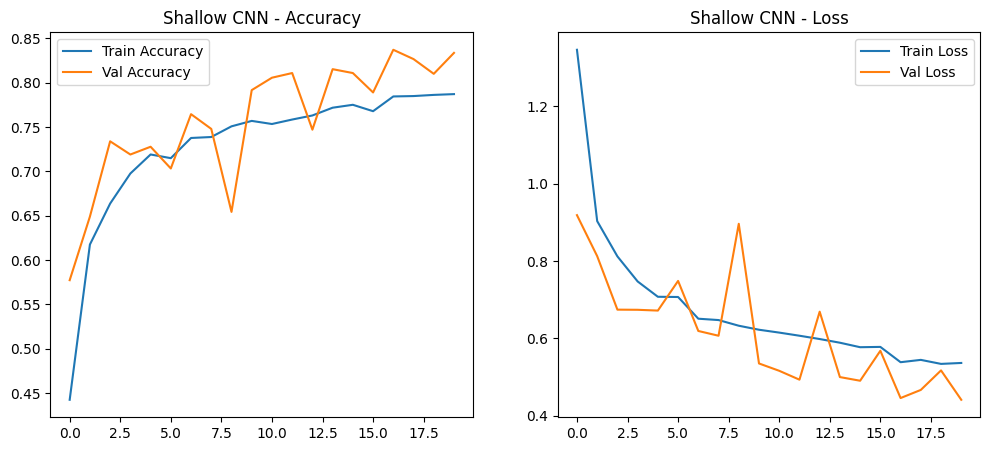

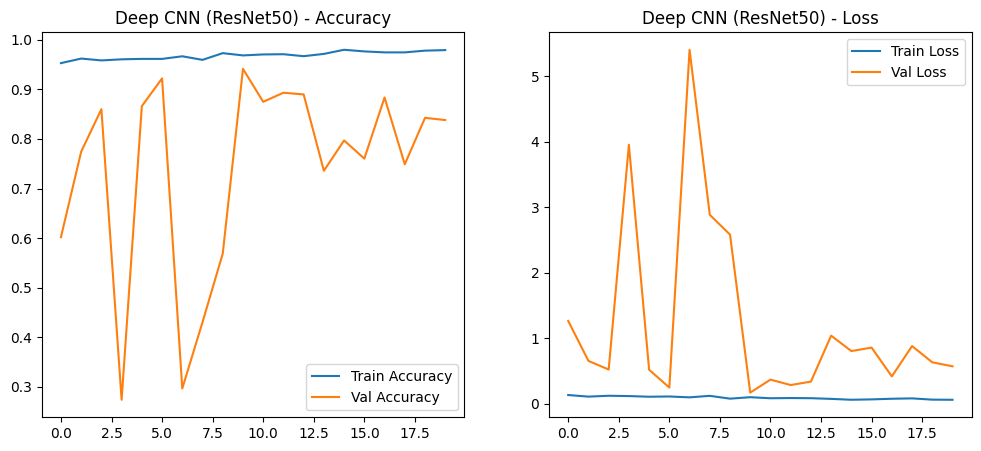

In [67]:

def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))

    #  accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    #  loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

#simple model
plot_training_history(history_simple, 'Simple Model')

#shallow CNN
plot_training_history(history_shallow, 'Shallow CNN')

#deep CNN
plot_training_history(history_deep, 'Deep CNN (ResNet50)')


In [69]:
train_acc_simple = history_simple.history['accuracy']
val_acc_simple = history_simple.history['val_accuracy']

train_acc_shallow = history_shallow.history['accuracy']
val_acc_shallow = history_shallow.history['val_accuracy']

train_acc_deep = history_deep.history['accuracy']
val_acc_deep = history_deep.history['val_accuracy']

train_loss_simple = history_simple.history['loss']
val_loss_simple = history_simple.history['val_loss']

train_loss_shallow = history_shallow.history['loss']
val_loss_shallow = history_shallow.history['val_loss']

train_loss_deep = history_deep.history['loss']
val_loss_deep = history_deep.history['val_loss']


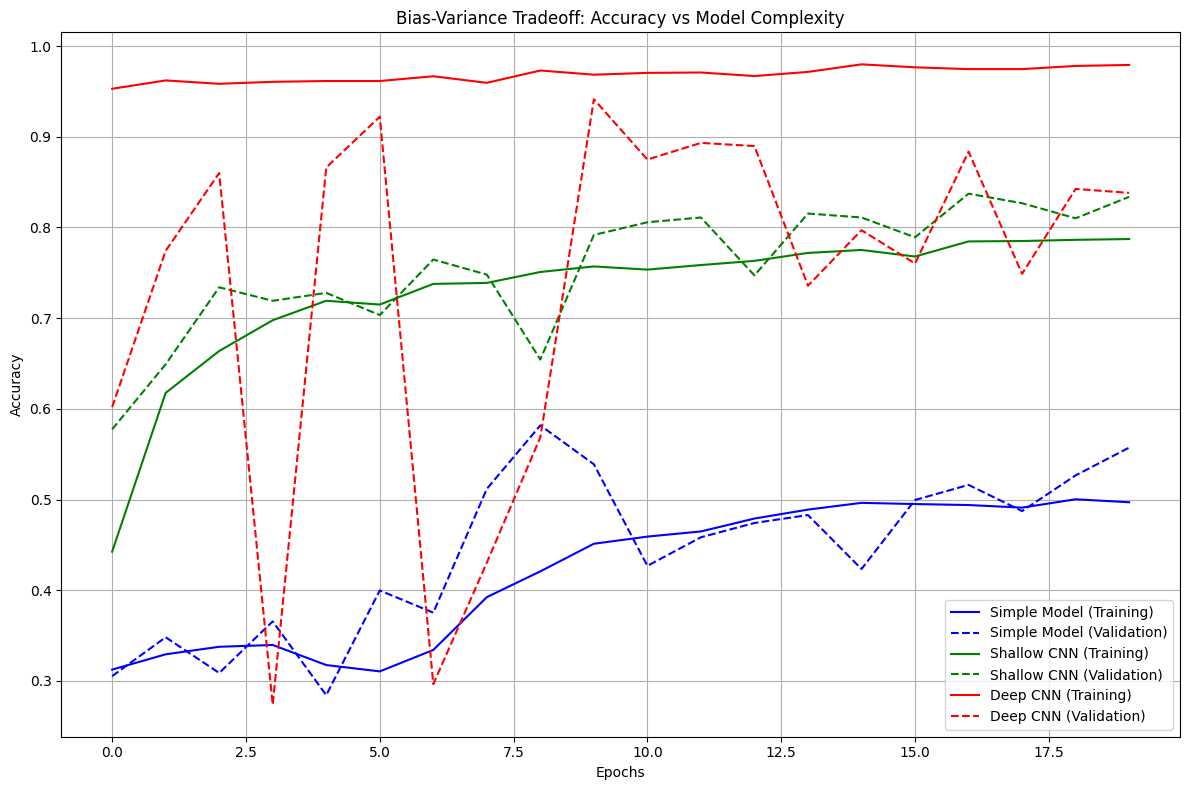

In [70]:
plt.figure(figsize=(12, 8))

# Simple model (high bias expected)
plt.plot(train_acc_simple, label='Simple Model (Training)', linestyle='-', color='blue')
plt.plot(val_acc_simple, label='Simple Model (Validation)', linestyle='--', color='blue')

# Shallow CNN (moderate bias and variance)
plt.plot(train_acc_shallow, label='Shallow CNN (Training)', linestyle='-', color='green')
plt.plot(val_acc_shallow, label='Shallow CNN (Validation)', linestyle='--', color='green')

# Deep CNN (low bias, potentially high variance)
plt.plot(train_acc_deep, label='Deep CNN (Training)', linestyle='-', color='red')
plt.plot(val_acc_deep, label='Deep CNN (Validation)', linestyle='--', color='red')

plt.title('Bias-Variance Tradeoff: Accuracy vs Model Complexity')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


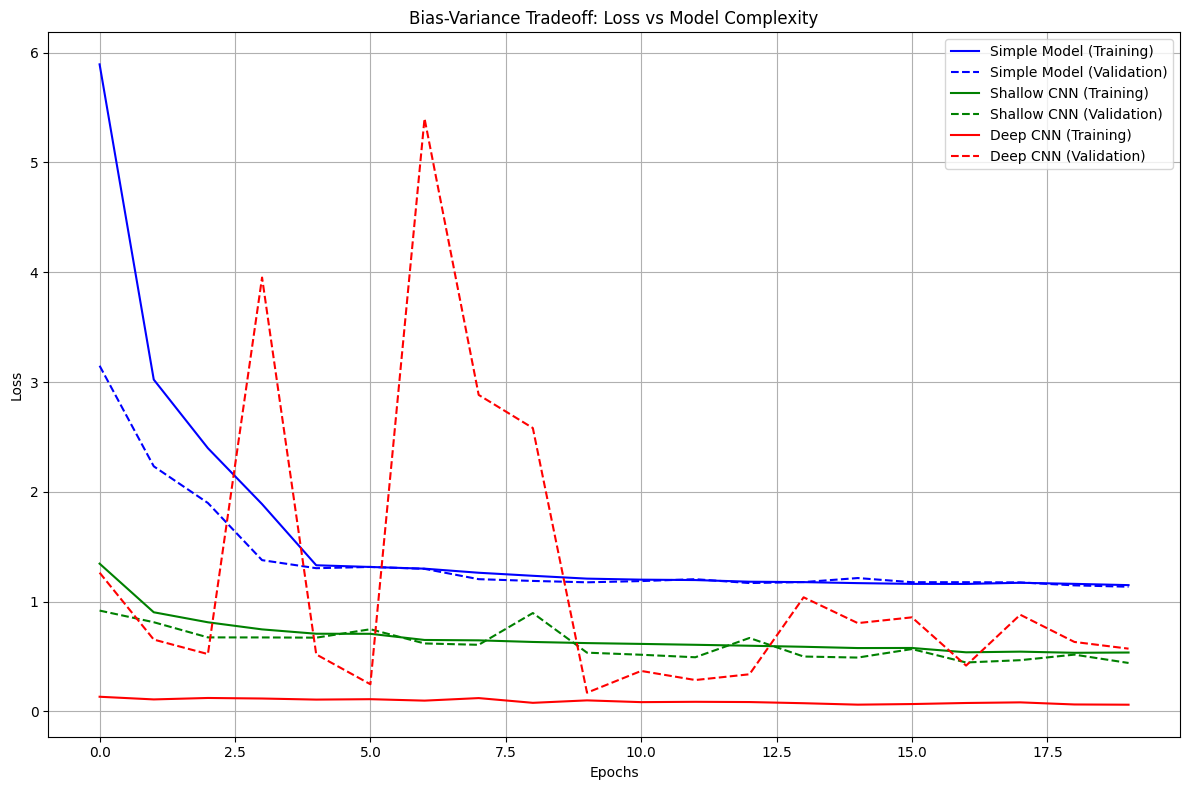

In [71]:
plt.figure(figsize=(12, 8))

# Simple model (high bias expected)
plt.plot(train_loss_simple, label='Simple Model (Training)', linestyle='-', color='blue')
plt.plot(val_loss_simple, label='Simple Model (Validation)', linestyle='--', color='blue')

# Shallow CNN (moderate bias and variance)
plt.plot(train_loss_shallow, label='Shallow CNN (Training)', linestyle='-', color='green')
plt.plot(val_loss_shallow, label='Shallow CNN (Validation)', linestyle='--', color='green')

# Deep CNN (low bias, potentially high variance)
plt.plot(train_loss_deep, label='Deep CNN (Training)', linestyle='-', color='red')
plt.plot(val_loss_deep, label='Deep CNN (Validation)', linestyle='--', color='red')

plt.title('Bias-Variance Tradeoff: Loss vs Model Complexity')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [72]:
bias_simple = 1 - history_simple.history['accuracy'][-1]  # Use final training accuracy for bias
variance_simple = abs(history_simple.history['accuracy'][-1] - history_simple.history['val_accuracy'][-1])

bias_shallow = 1 - history_shallow.history['accuracy'][-1]
variance_shallow = abs(history_shallow.history['accuracy'][-1] - history_shallow.history['val_accuracy'][-1])

bias_deep = 1 - history_deep.history['accuracy'][-1]
variance_deep = abs(history_deep.history['accuracy'][-1] - history_deep.history['val_accuracy'][-1])


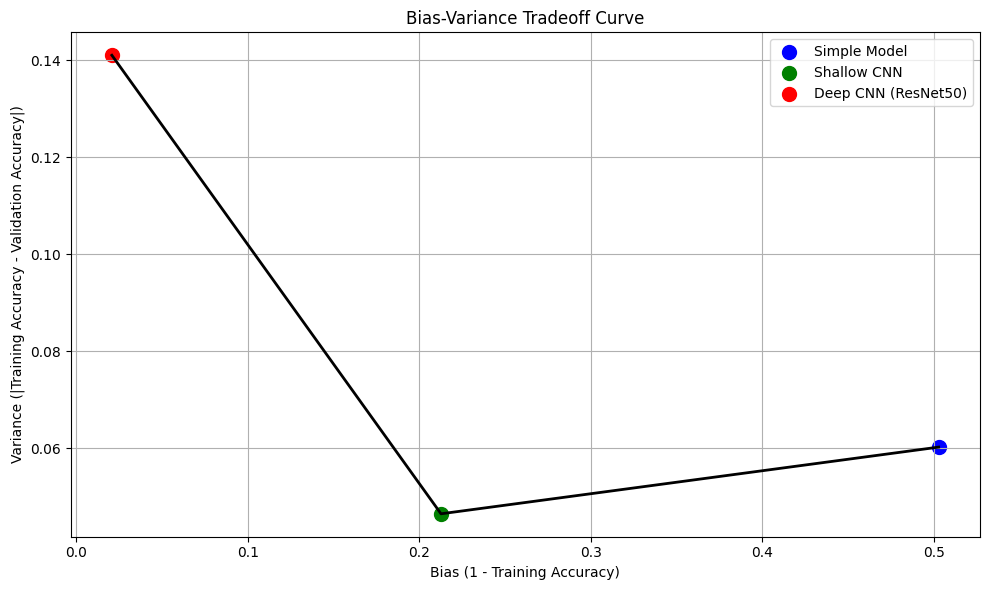

In [73]:
plt.figure(figsize=(10, 6))

plt.scatter(bias_simple, variance_simple, label='Simple Model', color='blue', s=100, marker='o')
plt.scatter(bias_shallow, variance_shallow, label='Shallow CNN', color='green', s=100, marker='o')
plt.scatter(bias_deep, variance_deep, label='Deep CNN (ResNet50)', color='red', s=100, marker='o')

plt.plot([bias_simple, bias_shallow, bias_deep], [variance_simple, variance_shallow, variance_deep], 
         color='black', linestyle='-', linewidth=2)

plt.title('Bias-Variance Tradeoff Curve')
plt.xlabel('Bias (1 - Training Accuracy)')
plt.ylabel('Variance (|Training Accuracy - Validation Accuracy|)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [74]:
# Simple model
bias_simple = 1 - history_simple.history['accuracy'][-1]  # final training accuracy for bias
variance_simple = abs(history_simple.history['accuracy'][-1] - history_simple.history['val_accuracy'][-1])  # difference for variance

# Shallow CNN
bias_shallow = 1 - history_shallow.history['accuracy'][-1]
variance_shallow = abs(history_shallow.history['accuracy'][-1] - history_shallow.history['val_accuracy'][-1])

# Deep CNN (ResNet50)
bias_deep = 1 - history_deep.history['accuracy'][-1]
variance_deep = abs(history_deep.history['accuracy'][-1] - history_deep.history['val_accuracy'][-1])


In [75]:
complexity = [1, 2, 3]  

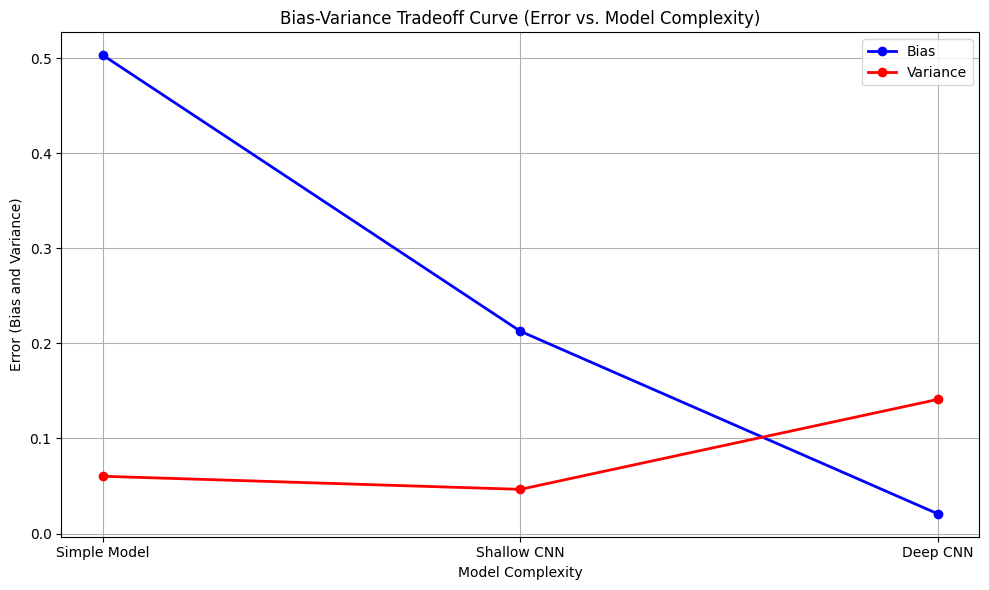

In [76]:
bias = [bias_simple, bias_shallow, bias_deep]
variance = [variance_simple, variance_shallow, variance_deep]

plt.figure(figsize=(10, 6))

plt.plot(complexity, bias, label="Bias", color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(complexity, variance, label="Variance", color='red', marker='o', linestyle='-', linewidth=2)

plt.title('Bias-Variance Tradeoff Curve (Error vs. Model Complexity)')
plt.xlabel('Model Complexity')
plt.ylabel('Error (Bias and Variance)')
plt.legend(loc='upper right')
plt.xticks(complexity, ['Simple Model', 'Shallow CNN', 'Deep CNN'])
plt.grid(True)
plt.tight_layout()
plt.show()


# Intermediate Model

In [58]:
intermediate_model = Sequential([
    Conv2D(32, (4, 4), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5, seed=42),
    Dense(len(CATEGORIES), activation="softmax")
])

In [62]:
# Model summary
from tensorflow.keras.optimizers import Adam
intermediate_model.summary()

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

intermediate_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 221, 221, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 107, 107, 64)        │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 50, 50, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 22, 22, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       7,930,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,080,878 (95.68 MB)

 Trainable params: 8,360,292 (31.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,720,586 (63.78 MB)

In [63]:
epochs = 20  
history_intermediate = intermediate_model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=val_generator  
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 109s 748ms/step - accuracy: 0.6989 - loss: 0.7885 - val_accuracy: 0.7883 - val_loss: 0.5284
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 107s 747ms/step - accuracy: 0.7399 - loss: 0.6470 - val_accuracy: 0.8451 - val_loss: 0.4611
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 754ms/step - accuracy: 0.7626 - loss: 0.6060 - val_accuracy: 0.8145 - val_loss: 0.4778
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 107s 745ms/step - accuracy: 0.7594 - loss: 0.5735 - val_accuracy: 0.7970 - val_loss: 0.5434
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 739ms/step - accuracy: 0.8079 - loss: 0.4973 - val_accuracy: 0.8425 - val_loss: 0.4202
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 740ms/step - accuracy: 0.8087 - loss: 0.4821 - val_accuracy: 0.8513 - val_loss: 0.4013
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 107s 744ms/step - accuracy: 0.8154 - loss: 0.4658 - val_accuracy: 0.8128 - val_loss: 0.4639
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 107s 746ms/step - accuracy: 0.8465 -

In [64]:
test_loss_intermediate, test_acc_intermediate = intermediate_model.evaluate(X_test, y_test)

print(f"Intermediate Model Test Accuracy: {test_acc_intermediate}")
print(f"Intermediate Model Test Loss: {test_loss_intermediate}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.8910 - loss: 0.3391
Intermediate Model Test Accuracy: 0.9138062596321106
Intermediate Model Test Loss: 0.261570543050766


# Confusion Matrix

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step


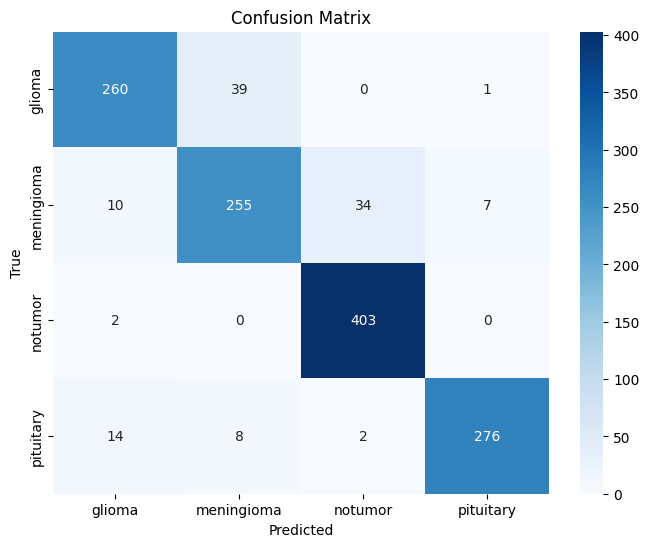

In [85]:
y_pred_intermediate = intermediate_model.predict(X_test)

y_pred_intermediate = (y_pred_intermediate > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_intermediate.argmax(axis=1))  # for multi-class

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()
